In [23]:
import torch
from torch import nn
from d2l import torch as d2l

n_train= 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)

def f(x):
    return 2 * torch.sin(x) + x ** 0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))
x_test = torch.arange(0, 5, 0.1)
y_truth = f(x_test)
n_test = len(x_test)
x_test, x_train

(tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000, 1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000,
         1.8000, 1.9000, 2.0000, 2.1000, 2.2000, 2.3000, 2.4000, 2.5000, 2.6000,
         2.7000, 2.8000, 2.9000, 3.0000, 3.1000, 3.2000, 3.3000, 3.4000, 3.5000,
         3.6000, 3.7000, 3.8000, 3.9000, 4.0000, 4.1000, 4.2000, 4.3000, 4.4000,
         4.5000, 4.6000, 4.7000, 4.8000, 4.9000]),
 tensor([0.0913, 0.2010, 0.4340, 0.4560, 0.4705, 0.6328, 0.6443, 0.6601, 0.9199,
         1.1290, 1.3637, 1.5467, 1.5713, 1.6021, 1.6034, 1.8015, 1.8594, 1.9736,
         2.0372, 2.2015, 2.2263, 2.3269, 2.3655, 2.3834, 2.4655, 2.6178, 2.7906,
         2.9833, 3.4788, 3.5966, 3.6036, 3.9698, 3.9821, 4.1100, 4.1478, 4.1854,
         4.2146, 4.2602, 4.3086, 4.4164, 4.5273, 4.5338, 4.6812, 4.7079, 4.7295,
         4.8481, 4.8761, 4.8778, 4.9221, 4.9970]))

In [24]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)

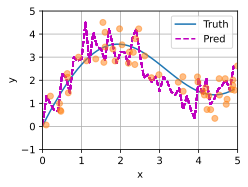

In [25]:
y_hat = torch.repeat_interleave(y_train.unsqueeze(1), n_test, 1)
plot_kernel_reg(y_hat)


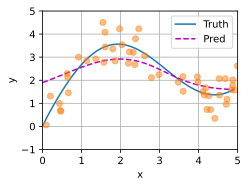

In [26]:
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# X_repeat
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

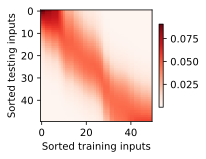

In [27]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')


In [28]:
weight = torch.ones((2, 10)) * 0.1
print(weight)
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weight.unsqueeze(1), values.unsqueeze(-1))

tensor([[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000]])


tensor([[[ 4.5000]],

        [[14.5000]]])

In [33]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))
    
    def forward(self, queries, keys, values):
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries -keys) * self.w)**2 / 2, dim=1)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)


In [34]:
X_tile = x_train.repeat((n_train, 1))
Y_tile = y_train.repeat((n_train, 1))
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))


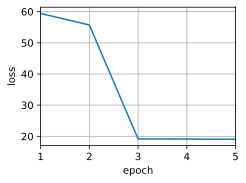

In [35]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l= loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))


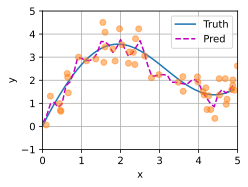

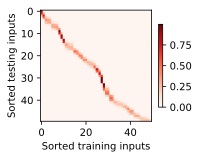

In [36]:
keys = x_train.repeat((n_train, 1))
values = y_train.repeat((n_train, 1))
y_hat = net(x_test,keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')


